In [96]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from category_encoders import OneHotEncoder

In [97]:
# Load the dataset
data = pd.read_csv('G:\CoachX\Data Science\Fraud_Detection.csv')

In [98]:
# Make a copy of the loaded dataset
df = data.copy()

In [99]:
# Initial data inspection
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Exploratory Data Analysis (EDA)

In [101]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [102]:
# Dealing with Outliers
# Define a function to detect and handle outliers using Z-score
def handle_outliers(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    outliers = (z_scores > threshold).any(axis=1)
    df_cleaned = df[~outliers]
    return df_cleaned

# Specify the numerical columns where outliers need to be handled
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Handle outliers in the specified numerical columns
df_handled = handle_outliers(df[numerical_columns])

# Check the shape of the cleaned dataset
print("Shape of cleaned dataset:", df_handled.shape)
df_handled.head()

Shape of cleaned dataset: (6090589, 5)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,170136.0,160296.36,0.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0
2,181.00,181.0,0.00,0.0,0.0
3,181.00,181.0,0.00,21182.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0


In [103]:
# Addressing Multicollinearity:
# Select only numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Calculate VIF for the numerical features
def calculate_vif(V):
    vif_data = pd.DataFrame()
    vif_data["feature"] = V.columns
    vif_data["VIF"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]
    return vif_data

V = df[numerical_columns]

# Calculate VIF for the numerical features
vif_results = calculate_vif(V)

# Display the VIF results
print("Variance Inflation Factor (VIF):")
print(vif_results)

Variance Inflation Factor (VIF):
          feature         VIF
0            step    1.191094
1          amount    4.078952
2   oldbalanceOrg  544.053103
3  newbalanceOrig  546.346008
4  oldbalanceDest   72.895522
5  newbalanceDest   84.584619
6         isFraud    1.188386
7  isFlaggedFraud    1.002546


## Data Cleaning & Filtering

In [104]:
# Data Cleaning
df=df.drop(columns=['isFlaggedFraud'])
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [105]:
# Drop rows where nameOrig starts with 'C' and nameDest starts with 'M' There are no Fraud transactions from Customer to Merchant
df_1 = df[~((df['nameOrig'].str.startswith('C')) & (df['nameDest'].str.startswith('M')))]
print(df_1)

         step      type      amount     nameOrig  oldbalanceOrg  \
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
9           1     DEBIT     5337.77   C712410124       41720.00   
10          1     DEBIT     9644.94  C1900366749        4465.00   
15          1  CASH_OUT   229133.94   C905080434       15325.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  
2                  0.00   C553264065            0.00            0.00        1  
3                  0.00    C3899701

In [107]:
# Filter out the fraud transactions
fraud_transactions = df_1[df_1['isFraud'] == 1]

# Filter out the non-fraud transactions
non_fraud_transactions = df_1[df_1['isFraud'] == 0]

# Randomly sample 8500 non-fraud transactions
non_fraud_sample = non_fraud_transactions.sample(n=8500, random_state=42)

# Combine the fraud transactions with the sampled non-fraud transactions
df_cleaned = pd.concat([fraud_transactions, non_fraud_sample])

# Reset the index for the combined DataFrame
df_cleaned.reset_index(drop=True, inplace=True)

# Print the resulting DataFrame
print(df_cleaned)


       step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0         1  TRANSFER     181.00  C1305486145         181.00            0.00   
1         1  CASH_OUT     181.00   C840083671         181.00            0.00   
2         1  TRANSFER    2806.00  C1420196421        2806.00            0.00   
3         1  CASH_OUT    2806.00  C2101527076        2806.00            0.00   
4         1  TRANSFER   20128.00   C137533655       20128.00            0.00   
...     ...       ...        ...          ...            ...             ...   
16708   235  CASH_OUT  108843.90  C1185167244           0.00            0.00   
16709    15  CASH_OUT  290733.31    C97199215       34661.26            0.00   
16710    18   CASH_IN  426903.89  C1895898401    25921998.23     26348902.11   
16711   286  TRANSFER  811968.34   C373559190           0.00            0.00   
16712    21  CASH_OUT  228199.40   C188748461           0.00            0.00   

          nameDest  oldbalanceDest  new

## Split the data into features (X) and target (y)

In [148]:

X = df_cleaned.drop(['isFraud'], axis=1)
y = df_cleaned['isFraud']

X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0


In [109]:
# Identify categorical and numeric columns
categorical_cols =['type']
numeric_cols = X.select_dtypes(include=['number']).columns

## Train Test Split

In [110]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# Drop rows with missing values in categorical columns
X_train_cleaned = X_train.dropna(subset=categorical_cols)
X_test_cleaned = X_test.dropna(subset=categorical_cols)


# Apply OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train_cleaned[categorical_cols])
X_test_encoded = encoder.transform(X_test_cleaned[categorical_cols])

In [112]:
# Standardize the data
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train_encoded)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test_encoded)

## Model Building & Evaluation

In [113]:
# Step 1: Build the model
model = RandomForestClassifier(random_state=42)


In [114]:
# Step 2: Train the model
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [115]:
# Step 3: Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

In [116]:
# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.690397846245887
ROC-AUC: 0.7711265134359742
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.87      0.74      1707
           1       0.79      0.50      0.61      1636

    accuracy                           0.69      3343
   macro avg       0.72      0.69      0.68      3343
weighted avg       0.72      0.69      0.68      3343

Confusion Matrix:
[[1484  223]
 [ 812  824]]


## Plotting the Results

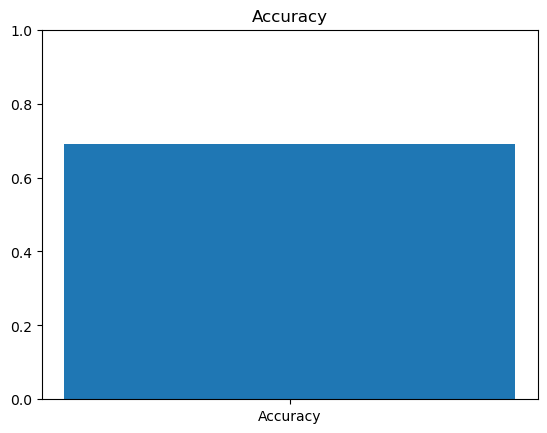

In [119]:
# Plot of Accuracy Score
plt.bar(["Accuracy"], [accuracy])
plt.title("Accuracy")
plt.ylim(0, 1)
plt.show()

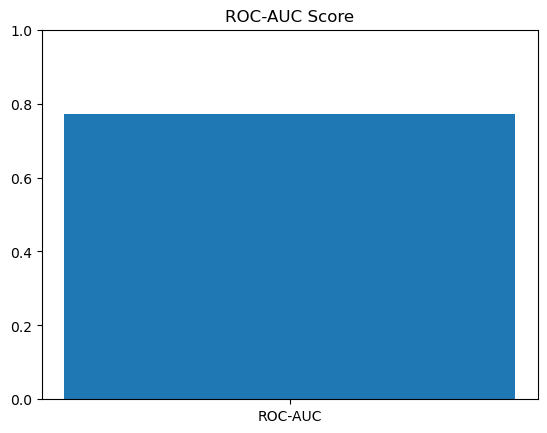

In [120]:
# Plot ROC-AUC score
plt.bar(["ROC-AUC"], [roc_auc])
plt.title("ROC-AUC Score")
plt.ylim(0, 1)
plt.show()


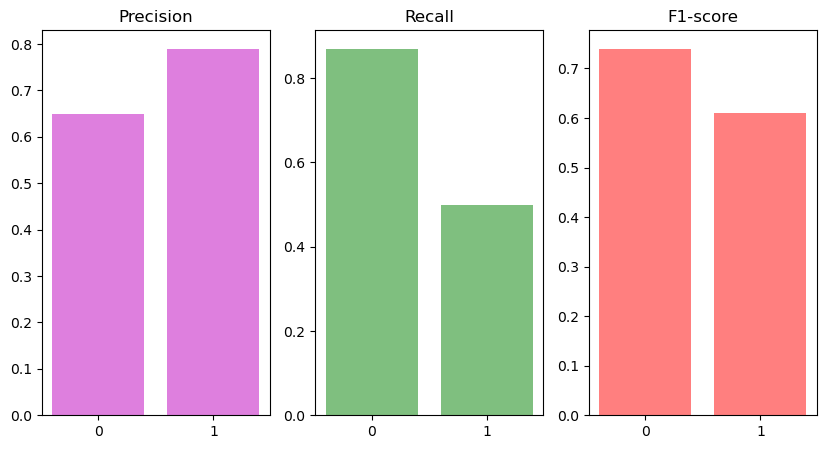

In [147]:
# Extract precision, recall, and F1-score from classification report
class_report = classification_rep.split('\n')[2:-5]
precision = [float(x.split()[1]) for x in class_report]
recall = [float(x.split()[2]) for x in class_report]
f1_score = [float(x.split()[3]) for x in class_report]
classes = [x.split()[0] for x in class_report]

# Plot precision, recall, and F1-score
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].bar(classes, precision, color='m', alpha=0.5)
ax[0].set_title('Precision')
ax[1].bar(classes, recall, color='g', alpha=0.5)
ax[1].set_title('Recall')
ax[2].bar(classes, f1_score, color='r', alpha=0.5)
ax[2].set_title('F1-score')
plt.show()


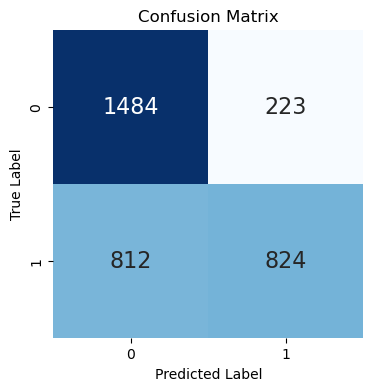

In [140]:
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
